In [1]:
from rl4co.envs import landuseOptEnv
import torch
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.models.nn.env_embeddings.context import LOPContext
from rl4co.models.nn.env_embeddings.dynamic import StaticEmbedding
from rl4co.models.nn.env_embeddings.init import lopInitEmbedding
from rl4co.envs.urbanplan.cityplan import init
import torch
from tensordict.tensordict import TensorDict

D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\fabric\__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
D:\Anaconda3\envs\rl4co\lib\site-packages\pkg_resources\__init__.py:2317: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('lightning.pytorch')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_r

In [2]:
''' neighbour to list '''
polygoncount = 221
neighbourlist = init.getneighbourlist('../Data/queen.csv', polygoncount)
basiclanduse = init.readlanduselist('../Data/baseParcels.shp', polygoncount)
landusePalette = {'Commercial': 'coral',
                  'Residential': 'peachpuff',
                  'Office': 'indianred',
                  'Residential&Commercial': 'lightsalmon',
                  'Green Space': 'lightgreen',
                  'Education': 'lightskyblue',
                  'Hospital': 'royalblue',
                  'SOHO': 'lightcoral'
                  }

landtype = ['Commercial', 'Residential', 'Office', 'Residential&Commercial', 'Green Space', 'Education', 'Hospital',
            'SOHO']
adj_matrix = init.get_adjacency_matrix('../Data/queen.csv', polygoncount)
import math
import numpy as np
shapefile = '../Data/Parcels.shp'


arealist = init.readarealist(shapefile, polygoncount)
locs_list = init.normalizeloc(shapefile)
locs = torch.tensor(locs_list, dtype=torch.float32).unsqueeze(0)
areas = torch.tensor(init.normalizearea(arealist), dtype=torch.float32).unsqueeze(0)
init_plan = torch.tensor(init.map_to_num(basiclanduse, landtype), dtype=torch.int64).unsqueeze(0)
fixed_mask = torch.ones_like(init_plan, dtype=torch.bool)
fixed_mask[(init_plan == 4) | (init_plan == 6)] = 0
neighbourlist = torch.tensor(adj_matrix).unsqueeze(0)
distances = torch.tensor(init.calculate_distance_matrix(locs_list), dtype=torch.float32).unsqueeze(0)
td = TensorDict(
    {
        "locs": locs,
        "areas": areas,
        "init_plan": init_plan,
        "fixed_mask": fixed_mask,
        "adjacency_list": neighbourlist,
        "distances": distances,
    },
    batch_size=1,
)

D:\Anaconda3\envs\rl4co\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
batch_size = 1024
env = landuseOptEnv(generator_params=dict(num_loc=50))
emb_dim = 128
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=lopInitEmbedding(emb_dim),
                              context_embedding=LOPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)
# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       baseline='rollout',
                       policy=policy,
                       )

D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.init_embed.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed.bias', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.weight', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.bias', 'baseline.baseline.policy.encoder.net.layers.0.0.module.out_proj.weight', 'baseline.baseline.policy.encoder.net.layers.0.0.module.out_proj.bias', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.weight', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.bias', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.running_mean', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.running_var', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.num_batches_tracked', 'baseline.baseline.policy.encoder.net.layers.0.2.module.lins.

reward: 3.0426323413848877
compatibility: 7.669999999999999
accessibility: -2.3903729227299224
reward: 2.686295509338379
compatibility: 7.503499999999999
accessibility: -2.5306299279165025
reward: 3.3606534004211426
compatibility: 7.6964999999999995
accessibility: -1.9760894505897522
reward: 2.2914609909057617
compatibility: 7.326500000000001
accessibility: -2.703771090535092
reward: 2.4175188541412354
compatibility: 7.248500000000002
accessibility: -2.3299914273273012
reward: 2.530979871749878
compatibility: 7.4215
accessibility: -2.5694390729741663
reward: 2.685241937637329
compatibility: 7.452000000000001
accessibility: -2.4102656163795064
reward: 3.4142422676086426
compatibility: 7.735000000000001
accessibility: -1.9868688245759165
reward: 2.813305139541626
compatibility: 7.462999999999998
accessibility: -2.2442173712709432
reward: 2.7483551502227783
compatibility: 7.434
accessibility: -2.2729743322866147
reward: 3.268639087677002
compatibility: 7.753000000000002
accessibility: -2.

D:\Anaconda3\envs\rl4co\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
E:\temp\DRLtest\rl4co\rl4co\envs\urbanplan\cityplan\render.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', np.unique(current_plan).size)


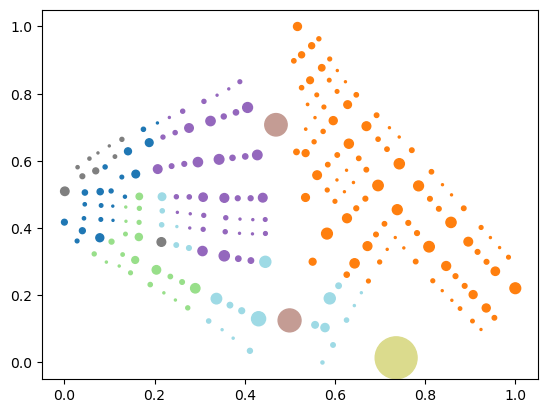

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = landuseOptEnv(generator_params=dict(num_loc=221)).to(device)
new_model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints/last.ckpt", strict=False)
policy_new = new_model_checkpoint.policy.to(device)
#env = new_model_checkpoint.env.to(device)
td_init = env.reset(td = td, batch_size=[1]).to(device)
print(td_init[0])
print(td_init[0].get("locs"))
print(td_init[0].get("areas"))
print(td_init[0].get("init_plan"))
print(td_init[0].get("adjacency_list"))
print(td_init[0].get("distances").tolist())
print(init.map_to_strings(td_init[0].get("init_plan").tolist(), landtype))
out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)